In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("data_ysm.xlsx")
print(df.head())


# In[2]:


df1 = df


# We need to do santity check about the data


# In[3]:


df1.TRANS_ID.nunique()
#df1.CARD_HOLDER.nunique()


# In[4]:


df1.isnull().sum(axis=0)


# In[5]:


df1.describe()


# In[6]:


df1.head()


# In[7]:


import datetime as dt
NOW = dt.datetime(2018,10,24)


# In[8]:


df1['OP_DATE_PRECISE'] = pd.to_datetime(df['OP_DATE_PRECISE'], format="%d/%m/%Y")
# Since recency is calculated for a point in time. The last invoice date is 2018-10-24, this is the date we will use to calculate recency.


# In[9]:


df1['OP_DATE_PRECISE'].min()


# In[10]:


df1['OP_DATE_PRECISE'].max()


# In[11]:


# Create a RFM table
rfmTable = df1.groupby('CARD_HOLDER').agg({'OP_DATE_PRECISE': lambda x: (NOW - x.max()).days, # Recency
                                        'TRANS_ID': lambda x: x.count(),      # Frequency
                                        'AMOUNT': lambda x: x.sum()}) # Monetary Value

rfmTable['OP_DATE_PRECISE'] = rfmTable['OP_DATE_PRECISE'].astype(int)
rfmTable.rename(columns={'OP_DATE_PRECISE': 'recency', 
                         'TRANS_ID': 'frequency', 
                         'AMOUNT': 'monetary_value'}, inplace=True)


# In[12]:


rfmTable.head()


# In[13]:


quantiles = rfmTable.quantile(q=[0.20,0.40,0.60,0.80])
quantiles


# In[14]:


quantiles = quantiles.to_dict()
quantiles


# In[15]:


segmented_rfm = rfmTable


# In[16]:


# Lowest recency, highest frequency and monetary are our best customers 
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 4
    else:
        return 5
    
def FMScore(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 2
    else:
        return 1


# In[17]:


segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
# Add segment numbers to the RFM table


# In[18]:


segmented_rfm.head()


# In[19]:


segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str)                             + segmented_rfm.f_quartile.map(str)                             + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()


# In[20]:


# Apparently, the first customer is not our best customer at all.

# Here is top 10 of our best customers!
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)


# In[21]:


rfm_scores = segmented_rfm.iloc[:,3:6]


# ## Clustering

# In[22]:





# In[23]:


#normalize
normalized_rfm = rfmTable.iloc[:, 0:3]
normalized_rfm.recency = (normalized_rfm.recency - normalized_rfm.recency.mean())/normalized_rfm.recency.std()
normalized_rfm.frequency = (normalized_rfm.frequency - normalized_rfm.frequency.mean())/normalized_rfm.frequency.std()
normalized_rfm.monetary_value = (normalized_rfm.monetary_value - normalized_rfm.monetary_value.mean())/normalized_rfm.monetary_value.std()



   CARD_HOLDER FIRST_NAME      SURNAME     TRANS_ID  AMOUNT OP_DATE_PRECISE
1      2289906      AYTAC  AĞAKİŞİYEVA  TM758251134    1.00      23/08/2017
2      2289906      AYTAC  AĞAKİŞİYEVA  TM758251135    1.19      23/08/2017
3      2289906      AYTAC  AĞAKİŞİYEVA  TM758251136    2.18      23/08/2017
4      2289906      AYTAC  AĞAKİŞİYEVA  TM754884437   15.15      16/08/2017
5      2289906      AYTAC  AĞAKİŞİYEVA  TM758797131    1.52      24/08/2017


In [2]:
import matplotlib.pyplot as plt
# Using the dendrogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(normalized_rfm, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
# Fitting Hierarchical Clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(normalized_rfm)


In [4]:
rfmTable['clusters'] = y_hc

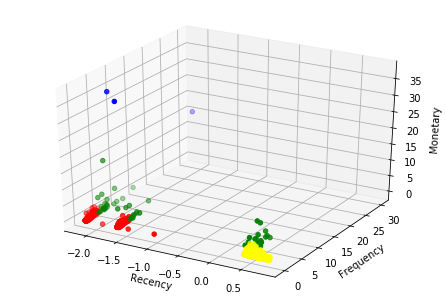

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

colors = ['blue', 'yellow', 'green', 'red', 'black']

for i in range(0,5):
    ax.scatter(normalized_rfm.recency[y_hc == i], normalized_rfm.frequency[y_hc == i], normalized_rfm.monetary_value[y_hc == i], c = colors[i])

In [7]:
aa = rfmTable[rfmTable.clusters == 1].describe()
aa

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,clusters
count,2831.000000,2831.000000,2831.000000,2831.000000,2831.000000,2831.000000,2831.0
mean,397.962557,8.410102,834.790456,3.529142,3.463440,3.136348,1.0
std,15.367719,10.990469,1755.228223,1.101452,1.417703,1.379733,0.0
min,383.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.0
25%,386.000000,2.000000,75.045000,3.000000,2.000000,2.000000,1.0
50%,391.000000,4.000000,258.500000,4.000000,4.000000,3.000000,1.0
75%,407.000000,10.000000,770.910000,4.000000,5.000000,4.000000,1.0
max,441.000000,77.000000,23872.270000,5.000000,5.000000,5.000000,1.0
